In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet152

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


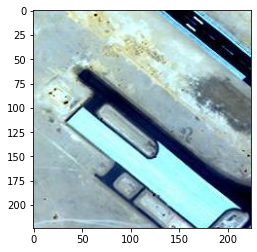

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
Resnet152WeightsPretrained = currentPath + os.sep + "resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Resnet152"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00008
batch_size = 10
num_epochs = 200
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 925 images belonging to 62 classes.
Found 309 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def ResnetCustom(shape,pretrainedweights, input_tensor, classes):
    RN152NoTop = ResNet152(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    RN152Out = RN152NoTop.layers[-1].output
    x = GlobalAvgPool2D()(RN152Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = ResnetCustom((img_rows, img_cols, img_channel),Resnet152WeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 58,497,982
Trainable params: 58,346,558
Non-trainable params: 151,424
__________________________________________________________________________________________________


In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 4s 1s/step - loss: 0.0880 - accuracy: 0.0000e+00 - val_loss: 0.0885 - val_accuracy: 0.0250 - lr: 8.0000e-05
Epoch 2/200
4/4 [==============================] - 2s 618ms/step - loss: 0.0857 - accuracy: 0.0250 - val_loss: 0.0959 - val_accuracy: 0.0000e+00 - lr: 8.0000e-05
Epoch 3/200
4/4 [==============================] - 2s 618ms/step - loss: 0.0893 - accuracy: 0.0250 - val_loss: 0.0909 - val_accuracy: 0.0000e+00 - lr: 8.0000e-05
Epoch 4/200
4/4 [==============================] - 2s 619ms/step - loss: 0.0888 - accuracy: 0.0250 - val_loss: 0.0908 - val_accuracy: 0.0500 - lr: 8.0000e-05
Epoch 5/200
4/4 [==============================] - 2s 619ms/step - loss: 0.0881 - accuracy: 0.0000e+00 - val_loss: 0.0967 - val_accuracy: 0.0000e+00 - lr: 8.0000e-05
Epoch 6/200
4/4 [==============================] - 2s 624ms/step - loss: 0.0898 - accuracy: 0.0000e+00 - val_loss: 0.

4/4 [==============================] - 2s 620ms/step - loss: 0.0785 - accuracy: 0.1250 - val_loss: 0.1090 - val_accuracy: 0.0000e+00 - lr: 8.0000e-09
Epoch 51/200
4/4 [==============================] - 2s 622ms/step - loss: 0.0763 - accuracy: 0.0750 - val_loss: 0.1116 - val_accuracy: 0.0000e+00 - lr: 8.0000e-09
Epoch 52/200
4/4 [==============================] - 2s 622ms/step - loss: 0.0771 - accuracy: 0.1250 - val_loss: 0.1083 - val_accuracy: 0.0000e+00 - lr: 8.0000e-10
Epoch 53/200
4/4 [==============================] - 2s 622ms/step - loss: 0.0783 - accuracy: 0.0750 - val_loss: 0.1000 - val_accuracy: 0.0250 - lr: 8.0000e-10
Epoch 54/200
4/4 [==============================] - 2s 623ms/step - loss: 0.0793 - accuracy: 0.0750 - val_loss: 0.1090 - val_accuracy: 0.0250 - lr: 8.0000e-10
Epoch 55/200
4/4 [==============================] - 2s 624ms/step - loss: 0.0742 - accuracy: 0.1500 - val_loss: 0.1077 - val_accuracy: 0.0000e+00 - lr: 8.0000e-10
Epoch 56/200
4/4 [=========================

Epoch 101/200
4/4 [==============================] - 3s 625ms/step - loss: 0.0813 - accuracy: 0.0500 - val_loss: 0.1011 - val_accuracy: 0.0250 - lr: 8.0000e-14
Epoch 102/200
4/4 [==============================] - 3s 625ms/step - loss: 0.0810 - accuracy: 0.0750 - val_loss: 0.0957 - val_accuracy: 0.0500 - lr: 8.0000e-15
Epoch 103/200
4/4 [==============================] - 3s 627ms/step - loss: 0.0762 - accuracy: 0.1000 - val_loss: 0.0998 - val_accuracy: 0.0250 - lr: 8.0000e-15
Epoch 104/200
4/4 [==============================] - 3s 625ms/step - loss: 0.0790 - accuracy: 0.0500 - val_loss: 0.0997 - val_accuracy: 0.0000e+00 - lr: 8.0000e-15
Epoch 105/200
4/4 [==============================] - 3s 625ms/step - loss: 0.0748 - accuracy: 0.0750 - val_loss: 0.0988 - val_accuracy: 0.0250 - lr: 8.0000e-15
Epoch 106/200
4/4 [==============================] - 2s 622ms/step - loss: 0.0790 - accuracy: 0.0750 - val_loss: 0.1064 - val_accuracy: 0.0000e+00 - lr: 8.0000e-15
Epoch 107/200
4/4 [=============

4/4 [==============================] - 3s 631ms/step - loss: 0.0796 - accuracy: 0.0250 - val_loss: 0.1000 - val_accuracy: 0.0250 - lr: 8.0000e-19
Epoch 152/200
4/4 [==============================] - 3s 630ms/step - loss: 0.0812 - accuracy: 0.0750 - val_loss: 0.0981 - val_accuracy: 0.0500 - lr: 8.0000e-20
Epoch 153/200
4/4 [==============================] - 3s 629ms/step - loss: 0.0790 - accuracy: 0.0750 - val_loss: 0.1011 - val_accuracy: 0.0250 - lr: 8.0000e-20
Epoch 154/200
4/4 [==============================] - 3s 630ms/step - loss: 0.0725 - accuracy: 0.1500 - val_loss: 0.1024 - val_accuracy: 0.0000e+00 - lr: 8.0000e-20
Epoch 155/200
4/4 [==============================] - 3s 629ms/step - loss: 0.0801 - accuracy: 0.0500 - val_loss: 0.1054 - val_accuracy: 0.0000e+00 - lr: 8.0000e-20
Epoch 156/200
4/4 [==============================] - 3s 630ms/step - loss: 0.0767 - accuracy: 0.1250 - val_loss: 0.0978 - val_accuracy: 0.0500 - lr: 8.0000e-20
Epoch 157/200
4/4 [===========================

In [13]:
model.save(currentPath + os.sep + "Resnet152Model.h5")
model.save_weights(currentPath + os.sep + "Resnet152Weights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


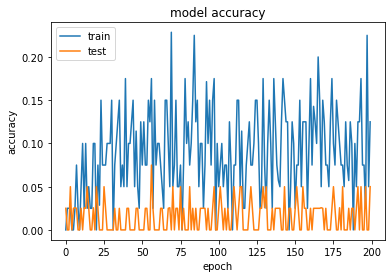

In [14]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

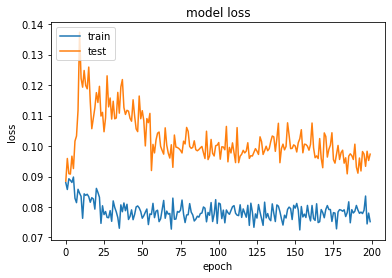

In [15]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [16]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: airport
file airport_11_7_msrgb.jpg is: airport
file airport_17_4_msrgb.jpg is: airport
file airport_25_0_msrgb.jpg is: airport
file airport_3_5_msrgb.jpg is: airport


In [18]:
loadedModel = load_model("Resnet152Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file zoo_12_6_msrgb.jpg is: airport
file zoo_16_0_msrgb.jpg is: airport
file zoo_19_6_msrgb.jpg is: airport
file zoo_37_6_msrgb.jpg is: airport
file zoo_8_2_msrgb.jpg is: airport
